# Traffic Prediction With Multilayer Perceptron

In this notebook, we are going to see the implementation of Multilayer Perceptron (or you may call it as ANN) for forecasting the traffic number/count of a certain area. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import math
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

# Importing Dataset & Visualize

In [2]:
df = pd.read_csv('/worspace/traffic/DataSet/train27303.csv')
df.head()

,timestamp,hourly_traffic_count
0,2015-10-04 00:00:00,3
1,2015-10-04 00:05:00,16
2,2015-10-04 00:10:00,9
3,2015-10-04 00:15:00,12
4,2015-10-04 00:20:00,19


In [3]:
df1 = df.reset_index()['hourly_traffic_count']
df1.head()

0     3
1    16
2     9
3    12
4    19
Name: hourly_traffic_count, dtype: int64

In [4]:
df1 = df1.iloc[:9792,]
df1.tail()

9787    23
9788    25
9789    16
9790    18
9791    25
Name: hourly_traffic_count, dtype: int64

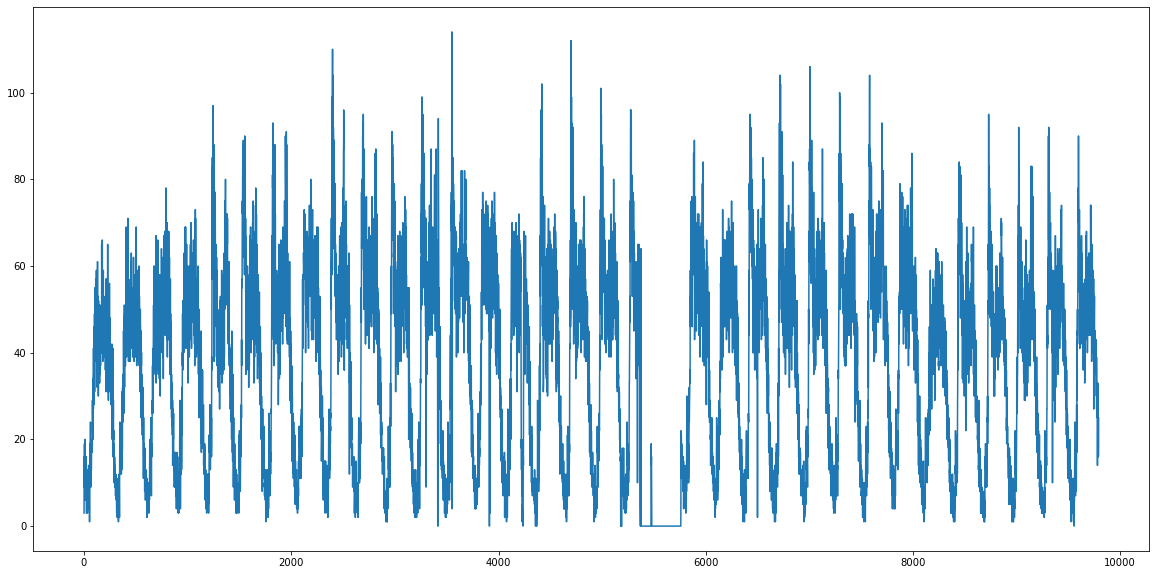

In [5]:
plt.figure(figsize=(20,10))
plt.plot(df1)
plt.show()

# Reshaping dataset with Window size=288 

In [6]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

# Feature Scaling for easier computaion

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Train test split (80% train, 20% test)

In [8]:
training_size = int(len(df1)*0.80)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [9]:
window = 288
X_train,y_train = create_dataset(train_data,window)
X_test, y_test = create_dataset(test_data,window)

# Multilayer perceptron Model

This is the exact model used in the Research Paper mentioned above. Just to avoid overfitting, I have changed the number of epochs from 2000 to 100. I tried with 2000 epochs, it causes overfitting, hence, providing a bad test score.

In [10]:
model = Sequential()
model.add(Dense(40, input_dim=window, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

In [11]:
opt  = keras.optimizers.Adagrad(learning_rate = 0.05)

In [12]:
model.compile(optimizer=opt ,loss='mean_squared_error')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                11560     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 15,691
Trainable params: 15,691
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 2/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 3/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 4/100
755/755 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 5/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 6/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 7/100
755/755 [==============================] - 2s 2ms/step - loss: 0.0050
Epoch 8/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 9/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 10/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 11/100
755/755 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 12/100
755/755 [==============================] - 2s 2ms/step - loss: 0.0047
Epoch 13/100


# Predicting the Future Traffic Count

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [16]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
train_predict = train_predict.astype(int)
test_predict = test_predict.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Accuracy Measures


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print('RMSE-train:',math.sqrt(mean_squared_error(y_train,train_predict)))
print('MAE-train:',mean_absolute_error(y_train,train_predict))
print('R_2-train:',r2_score(y_train,train_predict))

RMSE-train: 7.256994651229567
MAE-train: 5.279294803817604
R_2-train: 0.9072548593004606


In [19]:
print('RMSE-test:',math.sqrt(mean_squared_error(y_test,test_predict)))
print('MAE-test:',mean_absolute_error(y_test,test_predict))
print('R_2-train:',r2_score(y_test,test_predict))

RMSE-test: 7.516289694952099
MAE-test: 5.559281437125748
R_2-train: 0.8594664276366479


# Visualization

Blue line is the actual dataset, orange is the training and green is the test results


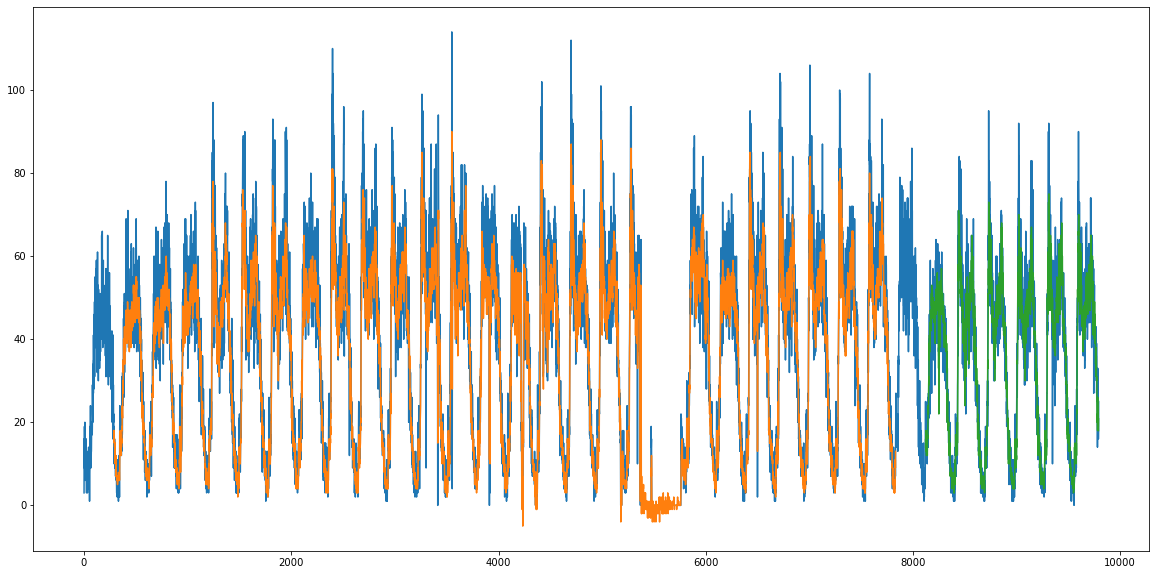

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(train_predict)+window, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(window*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **Conclusion**

In this notebook, we explore the application of a **Multilayer Perceptron (MLP)** model to predict traffic data, achieving an **85% R-squared score on test accuracy**. This result showcases the efficiency of **feedforward neural networks** for datasets without long-term dependencies, where **Multilayer Perceptrons (MLPs)** can excel in tasks like regression or classification.

**MLPs**, also known as **Artificial Neural Networks (ANNs)**, consist of multiple layers of neurons that are interconnected, making them capable of learning complex patterns in data. In this case, we used a basic MLP architecture to model the traffic data, which is primarily driven by seasonal patterns throughout each day. The dataset’s temporal nature, characterized by regular cycles and periodic fluctuations, makes it well-suited for this type of model, where dependencies between input features do not stretch over long time horizons.

While the **85% R-squared score** is a promising result, it is important to note that this can be further improved with **hyperparameter tuning**. Key parameters such as the number of hidden layers, the number of neurons per layer, activation functions, learning rates, and batch sizes all play a crucial role in fine-tuning the model's performance. Techniques like **Grid Search**, **Random Search**, or more advanced methods such as **Bayesian Optimization** can help find the optimal configuration, pushing the accuracy even further.

However, if the dataset contained **long-term dependencies** (e.g., trends or dependencies that span across several days or weeks), the performance of the MLP might not be as effective. In such cases, **Recurrent Neural Networks (RNNs)** or their more advanced versions, such as **LSTMs (Long Short-Term Memory)** and **GRUs (Gated Recurrent Units)**, are better suited. These models are specifically designed to capture and maintain information over long sequences, allowing them to remember previous time steps and use this historical context to make better predictions. While LSTMs and GRUs have a higher capacity for modeling long-term dependencies, they tend to be more computationally intensive.

However, for this particular traffic data, the **seasonal nature** of the dataset means that the long-term dependency is relatively less significant. **MLPs (or simple ANNs)** are able to capture these short-term dependencies efficiently, making them the optimal choice for this specific problem. The fact that the traffic data cycles through predictable patterns (e.g., morning rush hour, evening traffic) allows the MLP model to learn from the features and perform well in prediction tasks.

In summary, the use of a **Multilayer Perceptron** for traffic data prediction, achieving an **85% R-squared score**, demonstrates its effectiveness in scenarios where long-term dependencies are less pronounced. For datasets with more complex, long-term patterns, models like **LSTMs** or **GRUs** might provide superior results. Nevertheless, with proper hyperparameter tuning, the performance of MLPs can be significantly improved, making them a viable solution for many practical predictive modeling tasks.
